In [1]:
from dataclasses import astuple
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from src.loaders import FrameLoader, LabelsLoader


In [2]:
labels_loader = LabelsLoader('data/providentia_camera_dataset/labels')
frame_loader = FrameLoader('data/providentia_camera_dataset/images')

In [3]:
def get_intervals(values: List[int]) -> List[Tuple[int, int]]:
    splits = [i + 1 for i, (a, b) in enumerate(zip(values, values[1:])) if b - a != 1]
    splits = [0] + splits + [len(values)]
    intervals = [(values[a], values[b - 1]) for a, b in zip(splits, splits[1:])]
    return intervals


def print_intervals(indices: Dict[str, List[int]], label_counts: List[int]):
    for key, indices in indices.items():
        intervals = get_intervals(indices)
        s = key + ':\n  Indices: '
        s += ' + '.join(f'({a} -> {b})' for a, b in intervals)

        counts = [label_counts[i] for i in indices]
        min_i = min(range(len(counts)), key=lambda i: counts[i]) 
        max_i = max(range(len(counts)), key=lambda i: counts[i]) 

        s += f'\n  Label counts: total={sum(counts)}, mean={sum(counts)/len(counts):.0f}, min={counts[min_i]} [{min_i}], max={counts[max_i]} [{max_i}]\n'

        print(s)

In [4]:
sequences = {}
cameras = {}
label_counts = []
all_labels = []
for i, (labels, labels_info) in enumerate(labels_loader.load_items()):
    seq = labels_info['sequence']
    cam = labels_info['camera_channel']

    if seq not in sequences:
        sequences[seq] = []
    if cam not in cameras:
        cameras[cam] = []

    sequences[seq].append(i)
    cameras[cam].append(i)

    label_counts.append(len(labels))

    all_labels += labels


print('Camera:\n')
print_intervals(cameras, label_counts)
print('\nSequences:\n')
print_intervals(sequences, label_counts)

Camera:

s40_n_cam_far:
  Indices: (0 -> 119) + (540 -> 688)
  Label counts: total=7206, mean=27, min=7 [30], max=70 [87]

s40_n_cam_near:
  Indices: (120 -> 239) + (480 -> 539)
  Label counts: total=2150, mean=12, min=2 [45], max=29 [60]

s50_s_cam_far:
  Indices: (240 -> 359) + (689 -> 748)
  Label counts: total=2884, mean=16, min=1 [33], max=34 [129]

s50_s_cam_near:
  Indices: (360 -> 479) + (749 -> 808)
  Label counts: total=2262, mean=13, min=0 [34], max=35 [163]


Sequences:

2021_01_24_10_s40_n_cam_far:
  Indices: (0 -> 59)
  Label counts: total=895, mean=15, min=7 [30], max=27 [52]

2021_03_26_13_s40_n_cam_far:
  Indices: (60 -> 119) + (540 -> 688)
  Label counts: total=6311, mean=30, min=15 [129], max=70 [27]

2021_01_24_10_s40_n_cam_near:
  Indices: (120 -> 179)
  Label counts: total=533, mean=9, min=2 [45], max=18 [41]

2021_03_26_13_s40_n_cam_near:
  Indices: (180 -> 239)
  Label counts: total=1051, mean=18, min=7 [30], max=29 [0]

2021_01_24_10_s50_s_cam_far:
  Indices: (

In [5]:
parts = []
for i, (seq, indices) in enumerate(sequences.items()):
    intervals = get_intervals(indices)
    for interval in intervals:
        parts.append((seq, *interval))
parts.sort(key=lambda x: x[1])

fig = px.bar(label_counts, title='Label count per index and sequence')

max_y = max(label_counts)
for i, (seq, a, b) in enumerate(parts):
    if i % 2:
        fig.add_vrect(a, b, fillcolor='gray', opacity=0.2, line_width=0)
    fig.add_annotation(
        x=(a + b) / 2, y=max_y + 10 * (i % 2 + 1), text=seq, showarrow=False, font_size=10
    )

fig.update_layout(showlegend=False)

In [6]:
# Calculate mean dimensions per category.

categories = {}
for label in all_labels:
    if label.category not in categories:
        categories[label.category] = []
    categories[label.category].append(astuple(label.box3d.dimension))

max_characters = max(len(key) for key in categories.keys())

print(' ' * (max_characters + 1), 'len    width  height   count')
for category, dimensions in categories.items():
    dimensions = np.array(dimensions)
    length, width, height = dimensions.mean(0)
    print(
        (category + ':').ljust(max_characters + 1),
        f'{length:05.2f}, {width:05.2f}, {height:05.2f}    {dimensions.shape[0]}',
    )


                 len    width  height   count
CAR:             04.62, 01.96, 01.45    10085
VAN:             05.75, 02.06, 02.15    1389
TRAILER:         11.89, 02.52, 03.58    1208
TRUCK:           06.01, 02.53, 03.68    1419
BUS:             12.70, 02.58, 03.15    129
BICYCLE:         01.42, 00.48, 01.24    1
MOTORCYCLE:      02.32, 00.75, 01.64    33
SPECIAL_VEHICLE: 07.57, 02.33, 02.85    14
PEDESTRIAN:      00.55, 00.64, 01.75    224


In [7]:
# Percentiles for car lengths

lengths = np.array(categories['CAR']).T[0]
np.percentile(lengths, [1,99])

array([3.00352672, 5.34095095])

Camera:
s40_n_cam_far


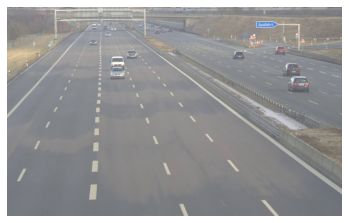

s40_n_cam_near


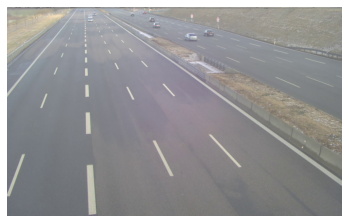

s50_s_cam_far


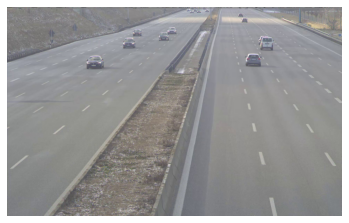

s50_s_cam_near


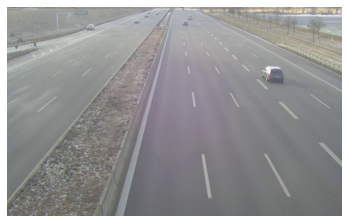


Sequences:
2021_01_24_10_s40_n_cam_far


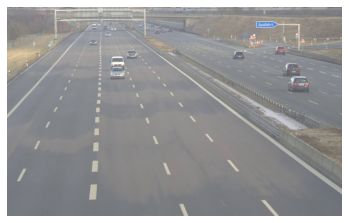

2021_03_26_13_s40_n_cam_far


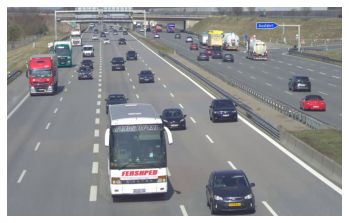

2021_01_24_10_s40_n_cam_near


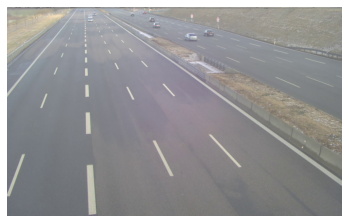

2021_03_26_13_s40_n_cam_near


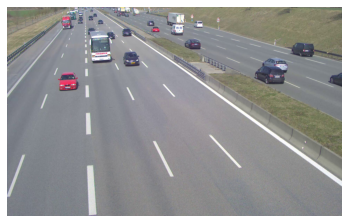

2021_01_24_10_s50_s_cam_far


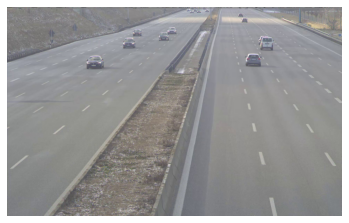

2021_03_26_13_s50_s_cam_far


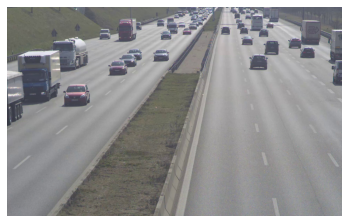

2021_01_24_10_s50_s_cam_near


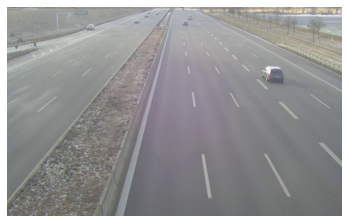

2021_03_26_14_s50_s_cam_near


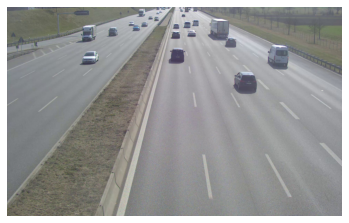

2021_03_26_14_s40_n_cam_near


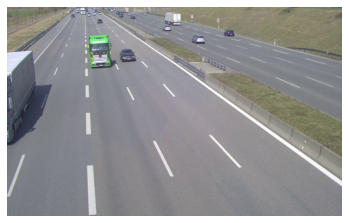

2021_03_26_14_s50_s_cam_far


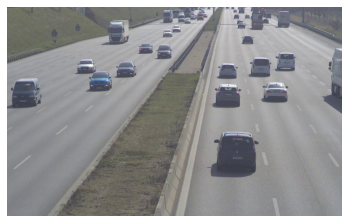

2021_04_08_11_s50_s_cam_near


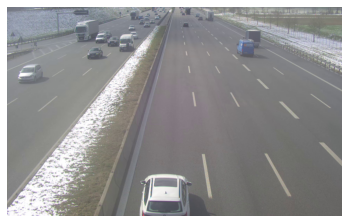

In [8]:
def show_images(indices: Dict[str, List[int]]):
    for key, indices in indices.items():
        image = frame_loader.load_item(indices[0])
        print(key)
        plt.imshow(image)
        plt.axis('off')
        plt.show()


print('Camera:')
show_images(cameras)
print('\nSequences:')
show_images(sequences)